In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import missingno as msno

# Load Data

In [2]:
clean_hdb_df1 = pd.read_csv('Processed_Data/hdb_data_with_coords_mrt_dist_id.csv',
    parse_dates=['month', 'lease_commence_date'])

# copy
df = clean_hdb_df1.copy()

### Exploratory Data Analysis

=== Data Quality Report ===

1. Basic Information:
Rows: 962,946
Columns: 23

2. Data Types:
remaining_lease                float64
floor_area_sqm                 float64
storey_range                    object
street_name                     object
lease_commence_date     datetime64[ns]
month                   datetime64[ns]
flat_type                       object
resale_price                   float64
town                            object
block                           object
flat_model                      object
storey_range_min                 int64
storey_range_max                 int64
full_address                    object
Latitude                       float64
Longitude                      float64
nearest_mrt_id                  object
mrt_name                        object
mrt_latitude                   float64
mrt_longitude                  float64
mrt_road                        object
Distance_from_MRT_km           float64
transaction_id                   int64
dtype: obj

/var/folders/y_/h86dm1h150v7bstq3mkcv4gm0000gn/T/ipykernel_5251/2745395831.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

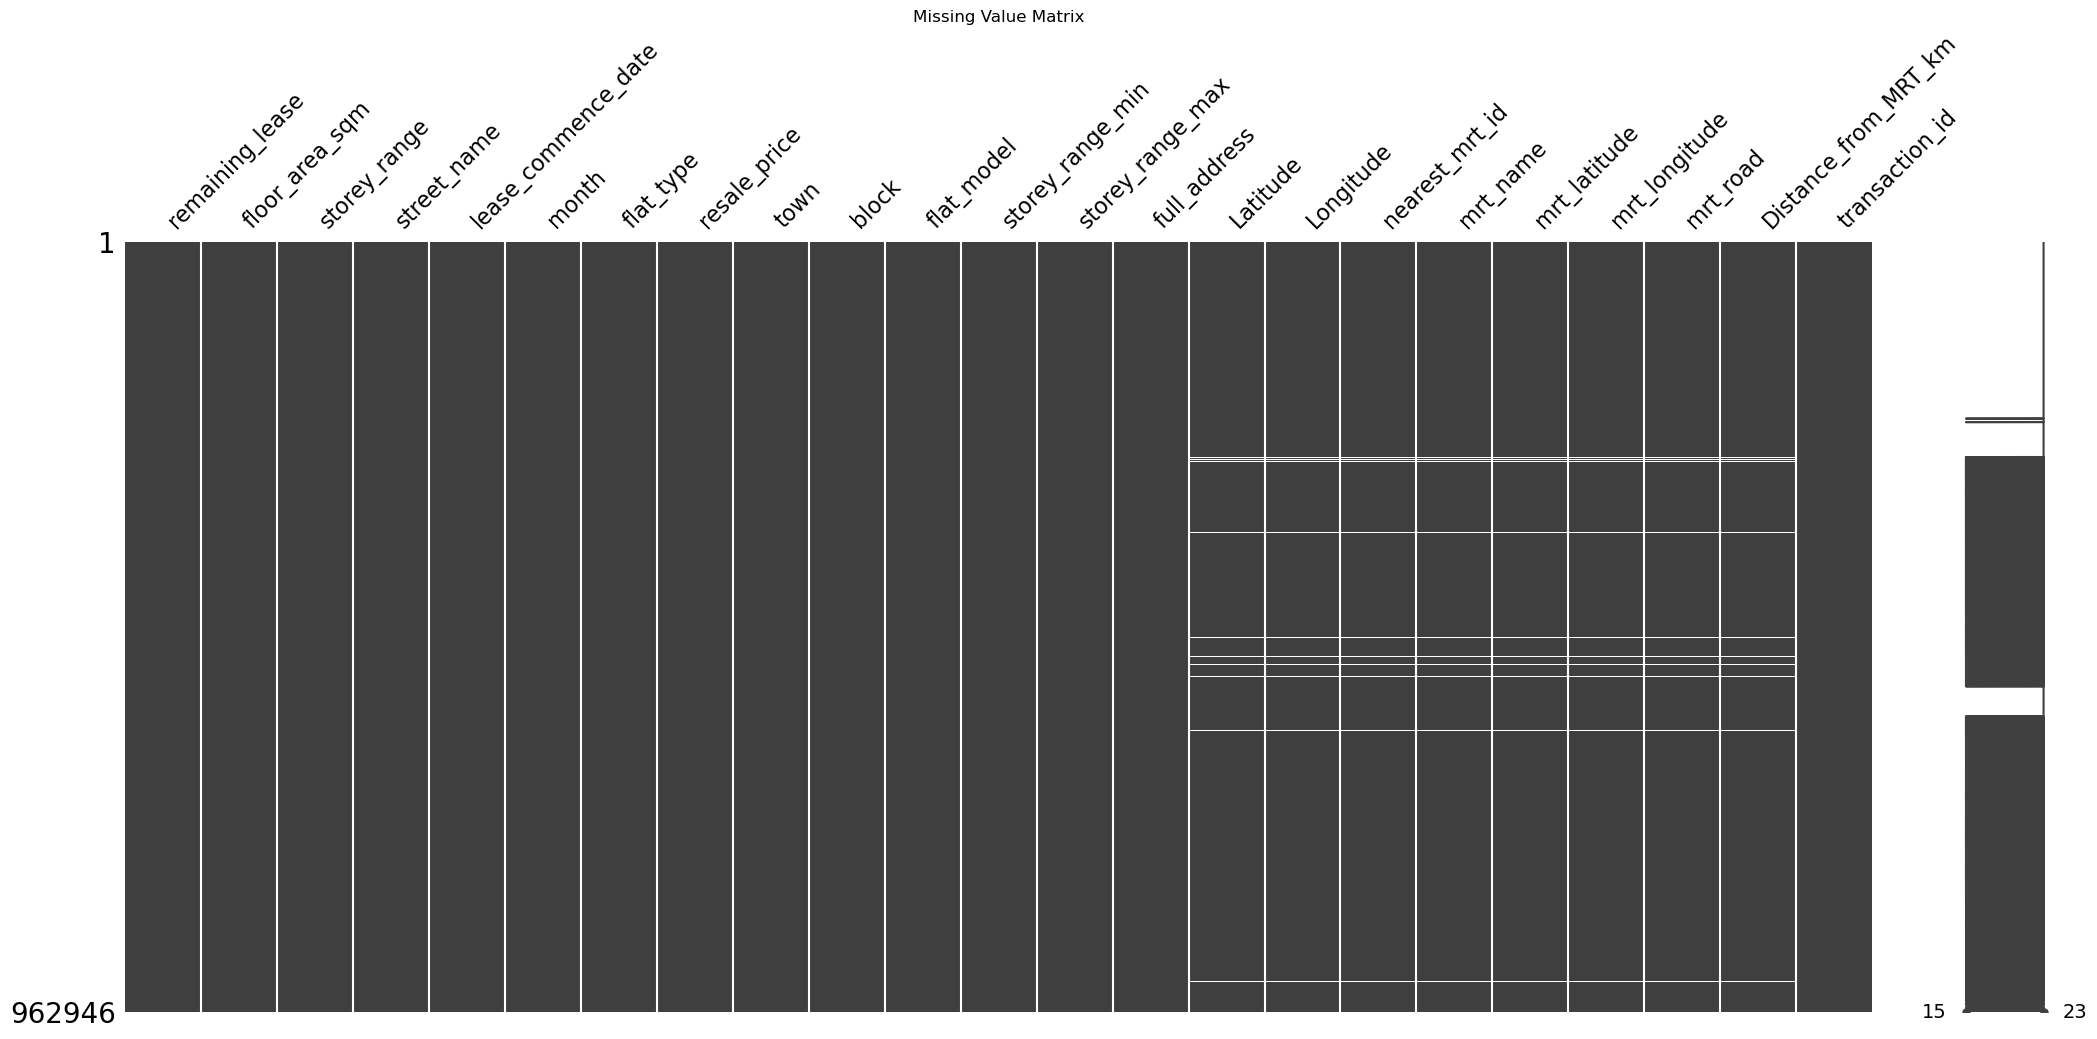

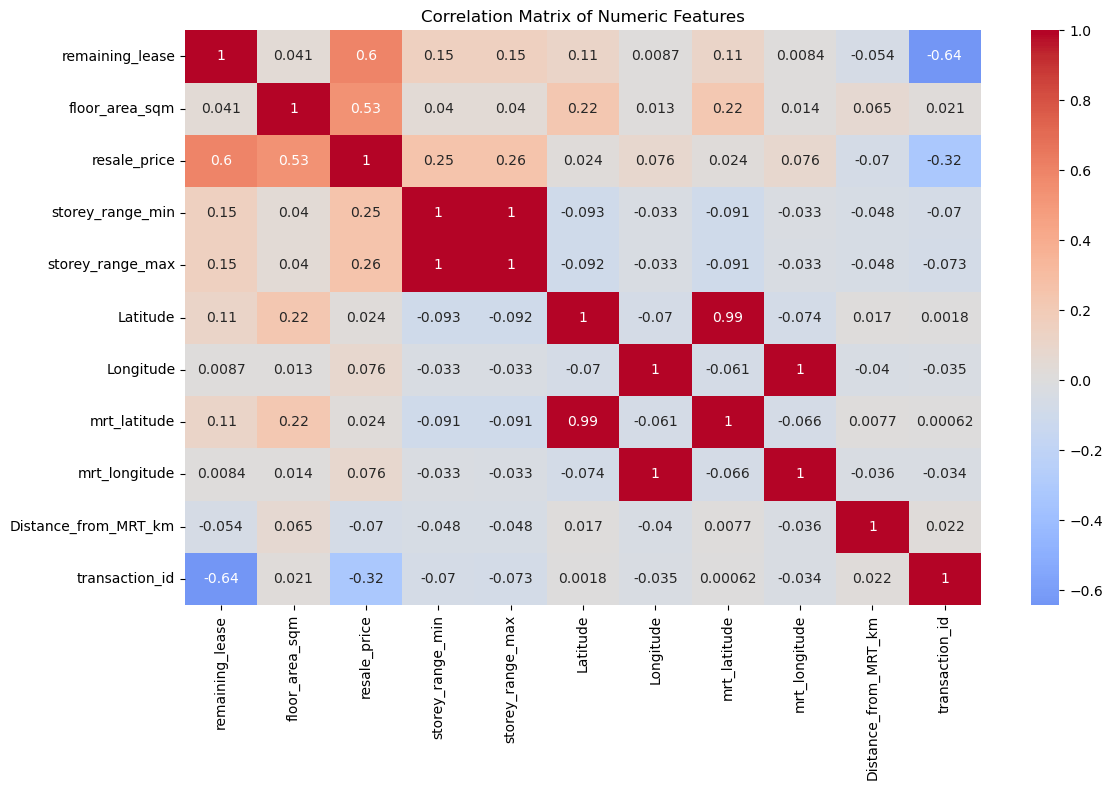

In [3]:
def check_data_quality(df):
    """
    Comprehensive data quality check for DataFrame
    """
    print("=== Data Quality Report ===\n")
    
    # Basic DataFrame Info
    print("1. Basic Information:")
    print(f"Rows: {df.shape[0]:,}")
    print(f"Columns: {df.shape[1]:,}")
    print("\n2. Data Types:")
    print(df.dtypes)
    
    # Missing Values
    print("\n3. Missing Values:")
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Values': missing,
        'Percentage': missing_pct
    })
    print(missing_df[missing_df['Missing Values'] > 0])
    
    # Infinite Values
    print("\n4. Infinite Values:")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    inf_counts = {col: np.sum(~np.isfinite(df[col])) for col in numeric_cols}
    inf_df = pd.DataFrame.from_dict(inf_counts, orient='index', columns=['Count'])
    print(inf_df[inf_df['Count'] > 0])
    
    # Zero Values (for numeric columns)
    print("\n5. Zero Values (numeric columns):")
    zero_counts = {col: (df[col] == 0).sum() for col in numeric_cols}
    zero_pct = {col: (zero_counts[col] / len(df)) * 100 for col in numeric_cols}
    zeros_df = pd.DataFrame({
        'Zero Count': zero_counts,
        'Zero Percentage': zero_pct
    })
    print(zeros_df[zeros_df['Zero Count'] > 0])
    
    # Unique Values (for categorical columns)
    print("\n6. Unique Values (categorical columns):")
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        n_unique = df[col].nunique()
        print(f"{col}: {n_unique:,} unique values")
    
    # Memory Usage
    print("\n7. Memory Usage:")
    memory_usage = df.memory_usage(deep=True).sum() / 1024**2  # in MB
    print(f"Total Memory Usage: {memory_usage:.2f} MB")

# Run the analysis
check_data_quality(df)

#Visual missing value analysis using missingno
plt.figure(figsize=(10, 6))
msno.matrix(df)
plt.title("Missing Value Matrix")
plt.tight_layout()
plt.show()

# Optional: Correlation heatmap for numeric columns
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), 
            annot=True, 
            cmap='coolwarm', 
            center=0)
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.show()

# Prepare Data for Model

In [4]:
def filter_data_for_modeling(clean_hdb_df, year_cutoff=2013):
    """
    Prepare and split HDB resale data into past and future datasets for modeling.

    This function performs the following steps:
    - Cleans the data by removing rows with missing or non-positive resale prices.
    - Converts 'month' and 'lease_commence_date' columns to datetime.
    - Computes additional features such as flat_age and extracts resale_year.
    - Splits the data into past and future datasets based on a specified cutoff year.

    Parameters
    ----------
    clean_hdb_df : pd.DataFrame
        The cleaned HDB resale dataset containing at least the following columns:
        'transaction_id', 'month', 'town', 'flat_type', 'flat_model', 'floor_area_sqm',
        'storey_range', 'lease_commence_date', 'remaining_lease', and 'resale_price'.

    year_cutoff : int, default=2013
        The year used to split the dataset into past and future. Transactions
        with resale_year <= year_cutoff are considered past, others are future.

    Returns
    -------
    past_feature_df : pd.DataFrame
        Features for transactions in the past period (resale_year <= year_cutoff).

    past_target_df : pd.DataFrame
        Target (resale_price) for past transactions.

    future_feature_df : pd.DataFrame
        Features for transactions in the future period (resale_year > year_cutoff).

    future_target_df : pd.DataFrame
        Target (resale_price) for future transactions.

    Notes
    -----
    - 'flat_age' is calculated in years and clipped at zero to avoid negative values.
    - The function preserves 'transaction_id' to allow merging features and targets.
    - Targets are not transformed inside this function; log-transformation can
      be applied separately if needed.
    """

    # Ensure month and lease_commence_date are datetime
    df = clean_hdb_df.copy()

    # Drop rows with missing or invalid price
    df = df[df["resale_price"].notnull() & (df["resale_price"] > 0)]

    #date type
    df["month"] = pd.to_datetime(df["month"])
    df["lease_commence_date"] = pd.to_datetime(df["lease_commence_date"], errors='coerce')

    # Features
    feature_df = pd.DataFrame({
        "transaction_id": df["transaction_id"],
        "resale_year": df["month"].dt.year,
        "town": df["town"],
        "flat_type": df["flat_type"],
        "flat_age": ((df["month"] - df["lease_commence_date"]).dt.days / 365.25).clip(lower=0),
        "flat_model": df["flat_model"],
        "floor_area_sqm": df["floor_area_sqm"],
        "storey_range": df["storey_range"],
        "remaining_lease": df["remaining_lease"]
    })

    # Targets (log-transform)
    target_df = pd.DataFrame({
        "transaction_id": df["transaction_id"],
        "resale_price": df["resale_price"]
    })

    # Split into past and future
    past_mask = feature_df["resale_year"] <= year_cutoff
    future_mask = feature_df["resale_year"] > year_cutoff

    past_feature_df = feature_df[past_mask].copy()
    future_feature_df = feature_df[future_mask].copy()

    past_target_df = target_df[past_mask].copy()
    future_target_df = target_df[future_mask].copy()

    return past_feature_df, past_target_df, future_feature_df, future_target_df


In [5]:
past_feature_df, past_target_df, future_feature_df, future_target_df = filter_data_for_modeling(df, year_cutoff=2016)

Test Train split on past data

In [6]:
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(
    past_feature_df, past_target_df, test_size=0.2, random_state=42
)


### One-hot encode categoricals, scale numerics

In [7]:
def preprocess_features_pipeline(feature_df, numeric_features=None, categorical_features=None, preprocessor=None, fit=True):
    """
    Preprocess a feature DataFrame for machine learning.

    This function handles both numeric and categorical features:
    - Numeric features are standardized using StandardScaler.
    - Categorical features are one-hot encoded using OneHotEncoder.
    
    It returns the preprocessed feature matrix and the preprocessor object.

    Parameters
    ----------
    feature_df : pd.DataFrame
        The input DataFrame containing features to preprocess.
        If a column named 'transaction_id' exists, it will be dropped automatically.
    
    numeric_features : list of str, optional
        List of numeric columns to scale. If None, all numeric columns
        (dtype int64 or float64) in the DataFrame will be used.
    
    categorical_features : list of str, optional
        List of categorical columns to encode. If None, all object or
        category dtype columns in the DataFrame will be used.
    
    preprocessor : ColumnTransformer, optional
        An existing preprocessor to use. If None, a new ColumnTransformer
        will be created with StandardScaler for numeric features and
        OneHotEncoder for categorical features.
    
    fit : bool, default=True
        If True, the preprocessor will be fit on the provided DataFrame.
        If False, the function will only transform the data using the
        provided preprocessor.

    Returns
    -------
    X_processed : np.ndarray
        The preprocessed feature matrix (numeric + encoded categorical features).
    
    preprocessor : ColumnTransformer
        The fitted ColumnTransformer object, which can be used to
        transform new data (e.g., test data) consistently.
    
    Notes
    -----
    - Always fit the preprocessor on the training data only to avoid
      data leakage. Use `fit=False` when transforming test or validation data.
    - This pipeline automatically handles unseen categories in categorical
      features by ignoring them.
    """
    
    df = feature_df.copy()
    if "transaction_id" in df.columns:
        df = df.drop(columns=["transaction_id"])

    if numeric_features is None:
        numeric_features = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
    if categorical_features is None:
        categorical_features = df.select_dtypes(include=["object", "category"]).columns.tolist()

    if preprocessor is None:
        preprocessor = ColumnTransformer(transformers=[
            ("num", StandardScaler(), numeric_features),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)
        ])

    if fit:
        X_processed = preprocessor.fit_transform(df)
    else:
        X_processed = preprocessor.transform(df)

    return X_processed, preprocessor


In [8]:
categorical_cols = ["town", "flat_type","flat_model", "storey_range"]
numeric_cols = ["resale_year", "flat_age", "floor_area_sqm", "remaining_lease"]


In [9]:
X_train, preprocessor = preprocess_features_pipeline(X_train_df, numeric_cols, categorical_cols, fit=True)
X_test, _ = preprocess_features_pipeline(X_test_df, numeric_cols, categorical_cols, preprocessor=preprocessor, fit=False)
X_future, _ = preprocess_features_pipeline(future_feature_df, numeric_cols, categorical_cols, preprocessor=preprocessor, fit=False)


# Modeling

I am using xgboost regressor that is a tree based model that utilizes Boosting mechanism for accurate predictions

In [10]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1 #use all cpus
)

In [11]:
# convert df to np array
y_train = y_train_df["resale_price"].values.astype(float)

In [12]:
xgb_model.fit(X_train,y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


# Model Testing

### Predicting with Test Data

In [13]:
y_test_predict=xgb_model.predict(X_test)
y_test = y_test_df["resale_price"].values.astype(float)
rmse = np.sqrt(mean_squared_error(y_test, y_test_predict))
mape = np.mean(np.abs((y_test - y_test_predict) / y_test)) * 100
r2 = r2_score(y_test, y_test_predict)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test Mean Absolute Percentage Error: {mape:.2f}%")
print(f"Test R^2 (Coefficient of Determination): {r2:.4f}")

if r2>0.9:
    print("Your predictive model is excellent!!")

Test RMSE: 23677.18
Test Mean Absolute Percentage Error: 7.04%
Test R^2 (Coefficient of Determination): 0.9711
Your predictive model is excellent!!


In [14]:
y_test_predict

array([288144.06, 236139.81, 332834.47, ..., 378360.34, 423806.44,
       271809.03], shape=(149241,), dtype=float32)

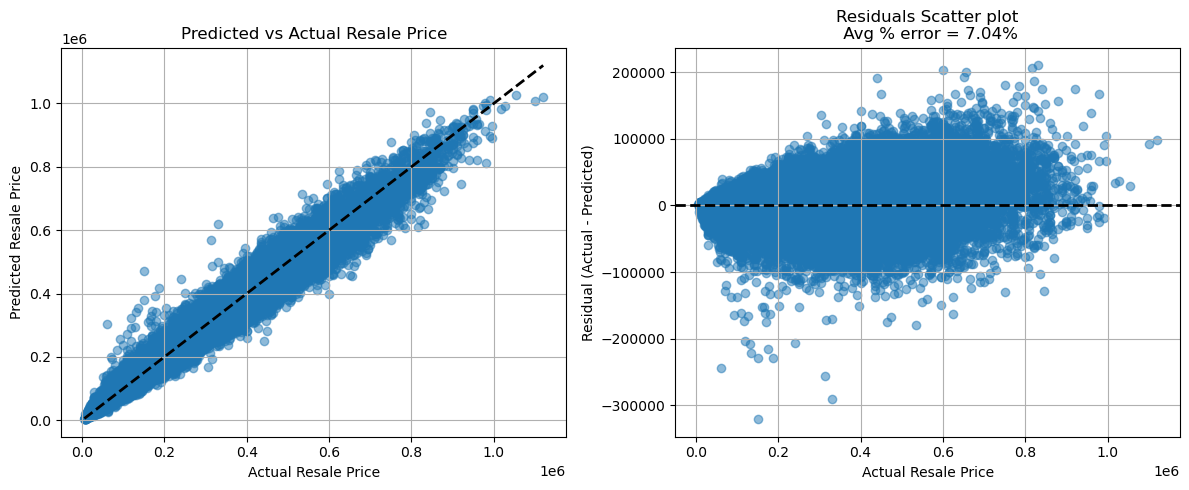

In [15]:
# Scatter plot: predicted vs actual resale prices
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_predict, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Resale Price')
plt.ylabel('Predicted Resale Price')
plt.title('Predicted vs Actual Resale Price')
plt.grid(True)

# RMSE as residual scatter plot
residuals = y_test - y_test_predict
rmse_values = rmse # Just absolute residuals (RMSE scalar but per-point residual = abs error)
#mape_values = np.abs((y_test - y_test_predict) / y_test) * 100

plt.subplot(1, 2, 2)
plt.scatter(y_test, residuals, alpha=0.5, label='Residuals')
plt.axhline(0, color='k', lw=2, linestyle='--')
plt.xlabel('Actual Resale Price')
plt.ylabel('Residual (Actual - Predicted)')
#plt.ylabel('Percentage Residual (Actual - Predicted)')
#plt.title(f'Residuals Scatter plot\nRMSE = {rmse:.2f} SGD')
plt.title(f'Residuals Scatter plot\n Avg % error = {mape:.2f}%')
plt.grid(True)

plt.tight_layout()
plt.savefig("figures/XGB_V2_2016_test_viz.pdf", dpi=300, bbox_inches='tight')
plt.show()




## Predicting with future data compared to threshold year 2016

### Full Future Data

In [16]:
y_future_predict=xgb_model.predict(X_future)

y_future_true = future_target_df["resale_price"].values.astype(float)

future_rmse = np.sqrt(mean_squared_error(y_future_true, y_future_predict))
future_mape = np.mean(np.abs((y_future_true - y_future_predict) / y_future_true)) * 100
future_r2 = r2_score(y_future_true, y_future_predict)

print(f"Test RMSE: {future_rmse:.2f}")
print(f"Test Mean Absolute Percentage Error: {future_mape:.2f}%")
print(f"Test R^2 (Coefficient of Determination): {future_r2:.4f}")

if future_r2>0.9:
    print("Your predictive model is excellent!!")

Test RMSE: 125306.54
Test Mean Absolute Percentage Error: 15.92%
Test R^2 (Coefficient of Determination): 0.5399


In [17]:
# Ensure all inputs have the same length
assert len(future_feature_df) == len(future_target_df)  == len(y_future_predict), \
    "All inputs must have the same number of rows"

# Combine the two DataFrames side by side
final_future_df = pd.merge(
    future_feature_df,
    future_target_df,
    on='transaction_id',
    how='inner'   # use 'left', 'right', or 'outer' if needed
)

# Add y_test and y_test_predict as new columns
final_future_df['y_future_predict'] = y_future_predict

# Display the combined DataFrame
print(final_future_df.head())


   transaction_id  resale_year        town flat_type   flat_age  \
0               1         2017  ANG MO KIO    2 ROOM  38.001369   
1               2         2017  ANG MO KIO    3 ROOM  39.000684   
2               3         2017  ANG MO KIO    3 ROOM  37.002053   
3               4         2017  ANG MO KIO    3 ROOM  37.002053   
4               5         2017  ANG MO KIO    3 ROOM  37.002053   

       flat_model  floor_area_sqm storey_range  remaining_lease  resale_price  \
0        Improved            44.0     10 TO 12        61.333333      232000.0   
1  New Generation            67.0     01 TO 03        60.583333      250000.0   
2  New Generation            67.0     01 TO 03        62.416667      262000.0   
3  New Generation            68.0     04 TO 06        62.083333      265000.0   
4  New Generation            67.0     01 TO 03        62.416667      265000.0   

   y_future_predict  
0      255634.03125  
1      290458.34375  
2      291000.40625  
3      303840.87500  


### Prediction for only Next Year

In [ ]:
future_df_nextyear= final_future_df[final_future_df['resale_year']==2017]
y_future_true= future_df_nextyear['resale_price'].values.astype(float)
y_future_predict= future_df_nextyear['y_future_predict'].values.astype(float)

future_residuals = y_future_true - y_future_predict

future_rmse_values = np.sqrt(mean_squared_error(y_future_true, y_future_predict))
future_mape_values = np.mean(np.abs((y_future_true - y_future_predict) / y_future_true)) * 100
future_r2_values = r2_score(y_future_true, y_future_predict)

print(f"RMSE: ${future_rmse_values:,.2f}")
print(f"Mean Absolute Percentage Error: {future_mape_values:.2f}%")
print(f"R^2 (Coefficient of Determination): {future_r2_values:.4f}")

RMSE: $42,545.24
Test Mean Absolute Percentage Error: 7.18%
Test R^2 (Coefficient of Determination): 0.9186


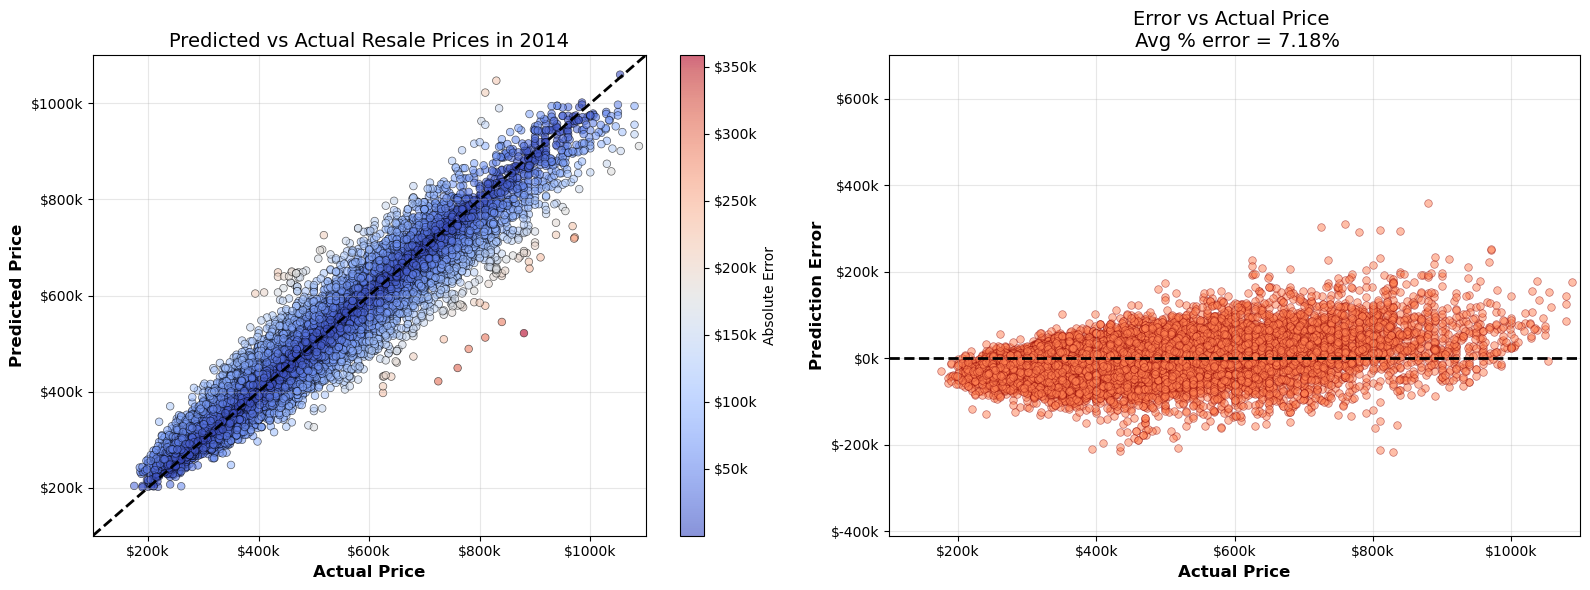

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Predicted vs Actual (color by error) ---
ax = axes[0]
abs_error = np.abs(y_future_true - y_future_predict)
scatter = ax.scatter(
    y_future_true, 
    y_future_predict, 
    c=abs_error,
    cmap='coolwarm',
    alpha=0.6,
    s=30,
    edgecolors='black',
    linewidth=0.5
)
#ax.plot([y_future_true.min(), y_future_true.max()],
#        [y_future_true.min(), y_future_true.max()], 'k--', lw=2)
x = np.linspace(100000, 1100000, 100)
ax.plot(x, x,'k--', linewidth=2, label=None)
ax.set_xlabel('Actual Price', fontsize=12, fontweight='bold')
ax.set_ylabel('Predicted Price', fontsize=12, fontweight='bold')
ax.set_title('Predicted vs Actual Resale Prices in 2014', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_xlim(100000, 1100000)
ax.set_ylim(100000, 1100000)
# Format axes in thousands with dollar sign
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}k'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}k'))

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Absolute Error', fontsize=10) 
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f'${y/1000:.0f}k'))

# --- Residuals ---
ax = axes[1]
ax.scatter(y_future_true, future_residuals, alpha=0.5, s=30, c='coral', edgecolors='darkred', linewidth=0.5)
ax.axhline(0, color='k', lw=2, linestyle='--')
ax.set_xlabel('Actual Price', fontsize=12, fontweight='bold')
ax.set_ylabel('Prediction Error', fontsize=12, fontweight='bold')
#ax.set_title(f'Coefficient of determination \n r2 = {future_r2_values:.2f}', fontsize=14)
ax.set_title(f"Error vs Actual Price \n Avg % error = {future_mape_values:.2f}%", fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_ylim(-410000, 700000)
ax.set_xlim(100000, 1100000)

# Format axes in thousands with dollar sign
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}k'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}k'))

plt.tight_layout()
plt.savefig("figures/XGB_V2_forecast_viz.pdf", dpi=300, bbox_inches='tight')
plt.show()

# Prediction for New Data

In [20]:
def predict_resale_price(model, actual_df, flat_type, town, flat_age, flat_model, floor_area_sqm, storey_range, remaining_lease, resale_year=2014):
    """
    Predict resale price for a specific flat
    
    Parameters:
    -----------
    model_results : xgboost results object
    training_columns : list of column names from training
    flat_type : str, e.g., '3 ROOM', '4 ROOM', '5 ROOM'
    town : str, e.g., 'ANG MO KIO', 'BEDOK'
    flat_age : float, age of flat in years
    resale_year : int, year of resale
    
    Returns:
    --------
    predicted_price : float
    """
    
    # Create input dataframe
    input_df = pd.DataFrame({
            'transaction_id': [0],  # Dummy ID
            'resale_year': [resale_year],
            'town': [town],
            'flat_age': [flat_age],
            'flat_type': [flat_type],
            "flat_model":[flat_model],
            "floor_area_sqm":[floor_area_sqm],
            "storey_range":[storey_range],
            "remaining_lease":[remaining_lease]
            })
    print(input_df.shape)
    
    X_input, _ = preprocess_features_pipeline(input_df,
            numeric_features=numeric_cols,
            categorical_features=categorical_cols,
            preprocessor=preprocessor,  # preprocessor fitted during training
            fit=False   
            )
  
    predicted_price = model.predict(X_input)

    # Find similar flats in actual data
    similar_flats = actual_df[
        (actual_df['flat_type'] == flat_type.upper()) &
        (actual_df['town'] == town.upper()) &
        (actual_df['flat_age'] >= flat_age - 15) &
        (actual_df['flat_age'] <= flat_age + 15) &
        (actual_df['flat_model'] == flat_model) &
        (actual_df['floor_area_sqm'] >= floor_area_sqm - 7) &
        (actual_df['floor_area_sqm'] <= floor_area_sqm + 7) &
        (actual_df['remaining_lease'] >= remaining_lease - 10) &
        (actual_df['remaining_lease'] <= remaining_lease + 10) &
        (actual_df['storey_range'] == storey_range.upper()) &
        (actual_df['resale_year'] == resale_year)
        #(actual_df['resale_year'] >= resale_year - 1) &
        #(actual_df['resale_year'] <= resale_year + 1)
    ]
    
    if len(similar_flats) > 0:
        print(f"\nSimilar Flats Found: {len(similar_flats)}")
        print(f"  Average Actual Price: ${similar_flats['resale_price'].mean():,.2f}")
        print(f"  Price Range: ${similar_flats['resale_price'].min():,.2f} - ${similar_flats['resale_price'].max():,.2f}")
        print(f"  Median: ${similar_flats['resale_price'].median():,.2f}")
    else:
        print("\nNo similar flats found in dataset")
    

    return predicted_price, similar_flats




In [21]:
actual_df=pd.merge(future_feature_df, future_target_df, on='transaction_id', how='inner')

In [22]:
#actual_df[actual_df["flat_type"]=="4 ROOM"]["flat_model"]
#np.mean(actual_df[actual_df["flat_type"]=="4 ROOM"]["floor_area_sqm"])

In [23]:
predicted_price, similar_flats = predict_resale_price(
    model=xgb_model,
    flat_type='4 ROOM',
    town='YISHUN',
    flat_age=(2017-1984),
    resale_year=2017,
    flat_model="New Generation", #Improved, New Generation, Model A, many more..
    floor_area_sqm= 91,
    storey_range="10 TO 12",
    remaining_lease=99-(2017-1984),
    actual_df=actual_df
    
)

print(f"\nPredicted Resale Price: {predicted_price[0]:.2f} SGD")

(1, 9)

Similar Flats Found: 22
  Average Actual Price: $382,502.36
  Price Range: $320,000.00 - $430,000.00
  Median: $385,500.00

Predicted Resale Price: 391081.25 SGD


# Validating a Transaction

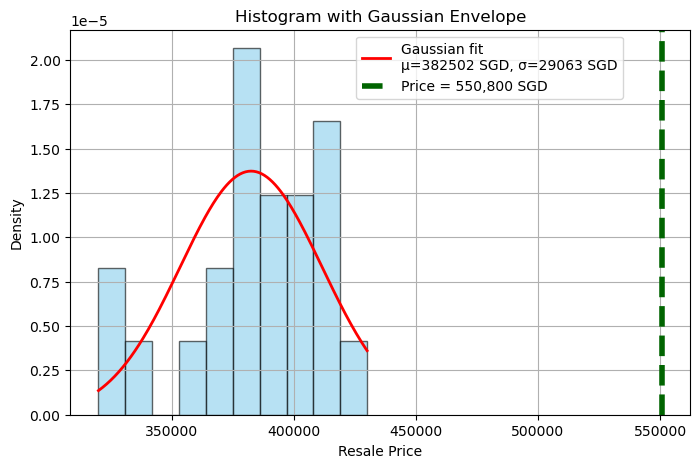

In [24]:
data = similar_flats["resale_price"]

mu, sigma = np.mean(data), np.std(data)

plt.figure(figsize=(8, 5))
count, bins, _ = plt.hist(data, bins=10, density=True, alpha=0.6, edgecolor='k', color='skyblue')

# Generate x values for smooth Gaussian curve, Compute Gaussian PDF (envelope), and Plot Gaussian curve on top
x = np.linspace(min(data), max(data), 200)
pdf = norm.pdf(x, mu, sigma)
plt.plot(x, pdf, 'r-', lw=2, label=f'Gaussian fit\nμ={mu:.0f} SGD, σ={sigma:.0f} SGD')

# vertical line at specific resale price 
plt.axvline(550800, color='darkgreen', linestyle='--', linewidth=4, label='Price = 550,800 SGD')

plt.xlabel("Resale Price")
plt.ylabel("Density")
plt.title("Histogram with Gaussian Envelope")
plt.legend(bbox_to_anchor=(0.45, 1), loc='upper left')
plt.grid(True)

plt.savefig("figures/XGB_V2_Market_check.pdf", dpi=300, bbox_inches='tight')
plt.show()